In [ ]:
from google.colab import drive
import pandas as pd

drive.mount('/content/gdrive', force_remount = True)
path = 'gdrive/My Drive/AML/feature_selected.csv'
df = pd.read_csv(path)

Mounted at /content/gdrive


In [ ]:
df.shape

(1056242, 34)

In [ ]:
#remove ['last_pymnt_amnt','recoveries'] because we want to focus on the information that would be available prior to lending the loan
#referenced other notebook on kaggle: annual_inc, issue_d, open_acc, pub_rec,  revol_bal, total_acc, initial_list_status, application_type, mort_acc, pub_rec_backrupcies

#22
nums = ['tot_cur_bal', 'annual_inc', 'revol_bal','bc_open_to_buy', 
        'loan_amnt', 'total_rec_int','mo_sin_old_rev_tl_op', 'mo_sin_old_il_acct',
        'mths_since_recent_bc', 'revol_util', 'mo_sin_rcnt_rev_tl_op','total_rec_late_fee', 
        'dti', 'mo_sin_rcnt_tl', 'open_acc', 'int_rate',
        'num_bc_tl', 'acc_open_past_24mths', 'num_actv_bc_tl', 'mort_acc',
        'num_tl_op_past_12m', 'num_accts_ever_120_pd']

#8
cats = ['term', 'sub_grade', 'last_credit_pull_d', 'home_ownership',
        'verification_status', 'zip_code', 'purpose', 'earliest_cr_line', 'loan_status']

In [ ]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score

import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
sc = StandardScaler()
enc = OneHotEncoder()

#num features : nums
cat_onehot = ['home_ownership', 'purpose']
cat_ord = ['term', 'sub_grade', 'verification_status']

terms_categories = [' 36 months', ' 60 months']
sub_grade_categories = list(reversed(['A1','A2','A3','A4','A5','B1','B2','B3','B4','B5','C1','C2','C3','C4','C5','D1','D2','D3','D4','D5','E1','E2','E3','E4','E5','F1','F2','F3','F4','F5','G1','G2','G3','G4','G5']))
verification_categories = ['Not Verified', 'Source Verified', 'Verified']


#Choose data based on variable selected
X = df[cat_onehot + cat_ord + nums]
print("X DataFrame=", X.shape)
y = df['loan_status'].map({'Fully Paid': 1, 'Charged Off': 0})
print("Y DataFrame=", y.shape)

X_dev, X_test, y_dev, y_test = train_test_split(X, y, stratify = y, test_size = 0.2, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, stratify = y_dev, test_size = 0.2, random_state = 84)

#Build transformer
sc = StandardScaler()
enc = OneHotEncoder()
ord = OrdinalEncoder(categories = [terms_categories, sub_grade_categories, verification_categories])

preprocess = make_column_transformer(
    (enc, cat_onehot),
    (ord, cat_ord),
    (sc, nums)
)

X DataFrame= (1056242, 27)
Y DataFrame= (1056242,)


1. Logistic Regression

In [ ]:
from sklearn.pipeline import Pipeline

pipe = Pipeline([('preprocess', preprocess), 
                 ('classifier', LogisticRegression())])
param_grid = {
    'classifier__penalty': ['elasticnet'],
    'classifier__C': [0.6, 0.8, 1, 1.2],
    'classifier__solver': ['saga'],
    'classifier__max_iter':[100, 150, 200],
    'classifier__warm_start': ['True'],
    'classifier__l1_ratio': [0.02, 0.1, 0.3]
}
grid_log = GridSearchCV(pipe, param_grid, cv = 3)
grid_log.fit(X_dev, y_dev)

In [ ]:
best_estimator = grid_log.best_estimator_
best_estimator.fit(X_dev, y_dev)

print(best_estimator.score(X_dev, y_dev))
print(best_estimator.score(X_test, y_test))
print(recall_score(y_test, best_estimator.predict(X_test), pos_label=1))
print(precision_score(y_test, best_estimator.predict(X_test), pos_label=1))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


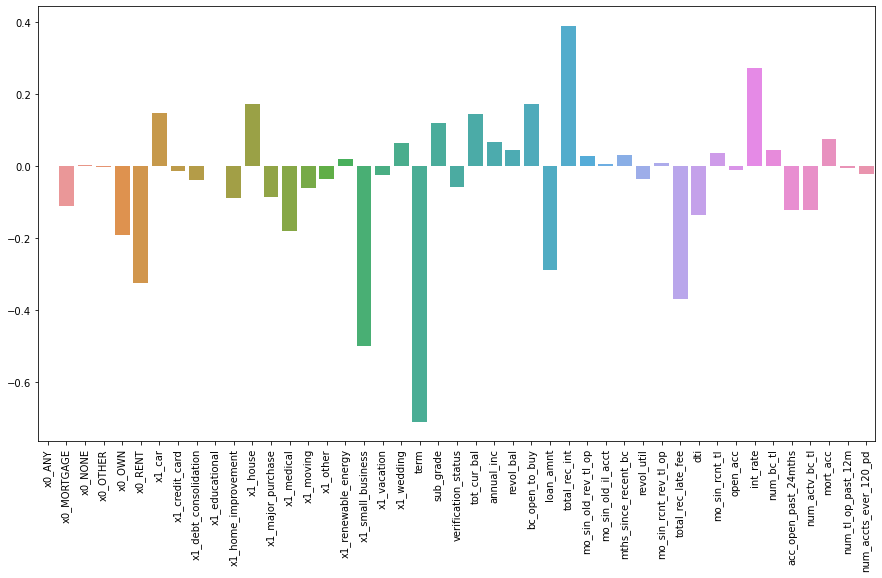

In [ ]:
features = list(best_estimator.named_steps['preprocess'].transformers_[0][1].get_feature_names()) + cat_ord + nums
coefs = best_estimator.named_steps['classifier'].coef_.tolist()[0]
plt.figure(figsize = (15, 8))
sns.barplot(features, coefs)
plt.xticks(rotation = 90)
plt.show()

2. Neural Network

In [ ]:
mlp = make_pipeline(preprocess, MLPClassifier())
mlp.fit(X_dev, y_dev)
print(mlp.score(X_dev, y_dev))
print(mlp.score(X_test, y_test))

0.8284660346298727
0.826105685707388


3. Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
pipe_rf = make_pipeline(preprocess, RandomForestClassifier(random_state = 22))
pipe_rf.fit(X_dev, y_dev)
print(f'Random Forest Classifier baseline score:', pipe_rf.score(X_test, y_test))

In [ ]:
n_estimators = [100, 200, 300]
max_depth = [10, 20, 30]

pipe_rf = make_pipeline(preprocess, GridSearchCV(RandomForestClassifier(random_state = 100, oob_score = True), 
                                                 param_grid = [{'n_estimators': n_estimators,
                                                                'max_depth': max_depth}],
                                                 cv = 10))
pipe_rf.fit(X_dev, y_dev)

In [ ]:
grid_search_results = pipe_rf.named_steps['gridsearchcv']
print('Best score of dev data set:', grid_search_results.best_score_)
print('Best Hyperparameters selected for Random Forest Classifier:',grid_search_results.best_params_)
print('Test score': pipe_rf.score(X_test, y_test))

y_pred = pipe_rf.predict(X_test)
print(f'Random Forest recall:', recall_score(y_test, y_pred))
print(f'Random Forest precision:', precision_score(y_test, y_pred))

In [ ]:
best_pipe_rf = make_pipeline(preprocess, 
                             RandomForestClassifier(n_estimators = 200, 
                                                    max_depth = 20,
                                                    random_state = 100, oob_score = True))
best_pipe_rf.fit(X_dev, y_dev)
rf = best_pipe_rf.named_steps['randomforestclassifier']

fi = zip(X.columns, rf.feature_importances_)
features, importance = zip(*(sorted(list(filter(lambda x: x[1] != 0, fi)), key = lambda x : x[1], reverse = True)))
ax = sns.barplot(list(features), list(importance))
ax.tick_params(axis = 'x', rotation = 90)

4. XGB

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


    
X = df.drop(['loan_status','last_pymnt_amnt','recoveries', 'last_credit_pull_d', 'earliest_cr_line', 'zip_code'], axis = 1)
y = df['loan_status'].map({'Fully Paid': 1, 'Charged Off': 0})

# No need to scale for trees. Encoding things before the split. 
cats = X.select_dtypes(['object']).columns
encoders = []
for cat in cats: 
    le = LabelEncoder()
    le.fit(df[cat])
    X[cat] = le.transform(X[cat])
    encoders.append(le)
    
X_dev, X_test, y_dev, y_test = train_test_split(X.values, y.values, stratify = y, test_size = 0.2, random_state = 42)

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

num = 10 # Number of folds/hyperparameter combinations to test

max_depths = np.random.randint(2, 15, num)
min_samples = np.random.randint(1, 100, num)
estimators = np.random.randint(50, 150, num)
learning_rate = [0.01,0.02,.03,.04,.05,.11,.12,.13,.14,.15]

params = dict(max_depth = max_depths, min_child_weight = min_samples, n_estimators = estimators, learning_rate = learning_rate)
xgb_models = RandomizedSearchCV(XGBClassifier(verbosity=0, silent=True, tree_method='gpu_hist', use_label_encoder=False), 
                                params, n_iter=num, random_state=42)
xgb_models.fit(X_dev, y_dev)

In [ ]:
best_xgb_model = xgb_models.best_estimator_
best_xgb_val_score = xgb_models.best_score_
best_xgb_index = xgb_models.best_index_
xgb_results = xgb_models.cv_results_['params'][best_xgb_index]

print('\nXGBClassifier\n{}-Fold Validation:'.format(num))
print('Best validation score: ', best_xgb_val_score) 
print('Best max depth: ', xgb_results['max_depth'])
print('Best min samples per leaf: ', xgb_results['min_child_weight'])
print('Best number of estimators: ', xgb_results['n_estimators'])
print('Best learning rate: ', xgb_results['learning_rate'])

'''
XGBClassifier
10-Fold Validation:
Best validation score:  0.8273169120065738
Best max depth:  13
Best min samples per leaf:  59
Best number of estimators:  121
Best learning rate:  0.11
'''

In [ ]:
from sklearn.metrics import accuracy_score

preds_test = best_xgb_model.predict(X_test)
xgb_precision = precision_score(y_test, preds_test, pos_label=1)
xgb_recall = recall_score(y_test, preds_test, pos_label=1)
print('XGB Precision: ', xgb_precision)
print('XGB Recall: ', xgb_recall)
print('XGB Accuracy: ', accuracy_score(y_test, preds_test))

'''
XGB Precision:  0.8443304849160633
XGB Recall:  0.96480535494099
XGB Accuracy:  0.8282169383050334
'''

In [ ]:
importances = best_xgb_model.feature_importances_
dic = {}
cols = X.columns
for k, v in enumerate(importances):
    dic[cols[k]] = v

sorted_importances = sorted(dic, key=dic.get, reverse=True)
print('Top 3 important features: ', sorted_importances[:3])

'''
Top 3 important features:  ['total_rec_late_fee', 'sub_grade', 'term']
'''

5. AdaBoost

In [ ]:
n_estimators_lst = [50, 100, 250, 500, 1000]
learning_rate_lst = [0.1, 0.5, 1]
val_accuracy = []

for n in n_estimators_lst:
    for l in learning_rate_lst:
        pipe_abc = Pipeline(steps=[('preprocess', preprocess),
                                   ('model', AdaBoostClassifier(n_estimators=n, learning_rate=l, random_state=1))])
        pipe_abc.fit(X_train, y_train)
        val_accuracy.append(pipe_abc.score(X_val, y_val))

In [ ]:
best_n = n_estimators_lst[np.argmax(val_accuracy)//3]
best_l = learning_rate_lst[np.argmax(val_accuracy)%3]
print('best train accuracy:', np.max(val_accuracy))
print('best n_estimators:', best_n)
print('best learning rate:', best_l)

In [ ]:
pipe_abc = Pipeline(steps=[('preprocess', preprocess),
              ('model', AdaBoostClassifier(n_estimators=best_n, learning_rate=best_l, random_state=1))])
pipe_abc.fit(X_dev, y_dev)
print('Test Accuracy', pipe_abc.score(X_test, y_test))
print('Test Recall',recall_score(y_val, pipe_abc.predict(X_val), pos_label=1))

In [ ]:
onehot_col = preprocess.named_transformers_['onehotencoder'].get_feature_names_out().tolist()
ordinal_col = cat_ord
standard_col = pipe_abc.named_steps['preprocess'].transformers_[2][2]
feature_name = onehot_col+ordinal_col+standard_col

d={}
for i, fimp in enumerate(pipe_abc.named_steps['model'].feature_importances_):
    d[feature_name[i]] = fimp

plt.figure(figsize = (15, 8))
sns.barplot(feature_name, pipe_abc.named_steps['model'].feature_importances_, order=sorted(d, key=d.get, reverse=True))
plt.xticks(rotation = 90)
plt.title('Feature Importances by AdaBoost')
plt.show()

6. CATBOOST

In [ ]:
pip install catboost

     |████████████████████████████████| 76.3 MB 28.4 MB/s 


In [ ]:
pip install category_encoders

     |████████████████████████████████| 82 kB 383 kB/s 


In [ ]:
from catboost import CatBoostClassifier
import category_encoders as ce

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#22
nums = ['tot_cur_bal', 'annual_inc', 'revol_bal','bc_open_to_buy', 
        'loan_amnt', 'total_rec_int','mo_sin_old_rev_tl_op', 'mo_sin_old_il_acct',
        'mths_since_recent_bc', 'revol_util', 'mo_sin_rcnt_rev_tl_op','total_rec_late_fee', 
        'dti', 'mo_sin_rcnt_tl', 'open_acc', 'int_rate',
        'num_bc_tl', 'acc_open_past_24mths', 'num_actv_bc_tl', 'mort_acc',
        'num_tl_op_past_12m', 'num_accts_ever_120_pd']

# included 5 of them
cats = ['term', 'sub_grade', 'home_ownership',
        'verification_status', 'purpose',]

features = nums + cats 
target = ["loan_status"]

X = df[features]
y = df['loan_status'].map({'Fully Paid': 1, 'Charged Off': 0})
                          
print(X.shape)
print(y.shape)

(1056242, 27)
(1056242,)


In [ ]:
X_dev, X_test, y_dev, y_test = train_test_split(X, y, stratify = y, test_size = 0.2, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, stratify = y_dev, test_size = 0.2, random_state = 84)

print(X_dev.shape)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(844993, 27)
(675994, 27)
(168999, 27)
(211249, 27)


In [ ]:
from catboost import CatBoostClassifier

In [ ]:
# Since CATBOOST had this extra functionality of Target Encoding, included this, so that we can explain 
# this as part of documentation that we used catboost to try out this functionality and also overfitting detection, which I
# have included in the code

cbe_encoder = ce.cat_boost.CatBoostEncoder()
dev_cbe = cbe_encoder.fit_transform(X_dev, y_dev)
train_cbe = cbe_encoder.fit_transform(X_train, y_train)
val_cbe = cbe_encoder.fit_transform(X_val, y_val)
test_cbe = cbe_encoder.transform(X_test)

print(train_cbe.shape)
print(val_cbe.shape)
print(test_cbe.shape)

(675994, 27)
(168999, 27)
(211249, 27)


In [ ]:
import random
learning_rate = [0.01,0.02,.03,.04,.05,.11,.12,.13,.14,.15]
bootstrap_type = ["Bayesian","Bernoulli","MVS"]
count=0
#setting count to 10 for hyperparameter-tuning 

while(count!=10):
    numTrees = random.randint(1000,2500)
    Depth = random.randint(1, 10)
    l2Leaf_Reg = random.randint(3,7)
    borderCount=random.randint(25,100)
    learningRate = learning_rate[random.randint(0,9)]
    bootstrapType = bootstrap_type[random.randint(0,2)]

    model= CatBoostClassifier(random_state=42,verbose=False,
                              num_trees=numTrees, 
                              depth=Depth, 
                              border_count=borderCount,
                              learning_rate=learningRate, 
                              bootstrap_type=bootstrapType, 
                              l2_leaf_reg = l2Leaf_Reg,
                              od_pval=0.001, #overfitting detector
                              eval_metric="Accuracy", #overfitting detector
                              task_type="GPU") 

    model.fit(train_cbe,y_train, 
              use_best_model=True, #overfitting detector
              eval_set=(val_cbe, y_val) #overfitting detector
              )
    print("numTrees",numTrees, "Depth=",Depth, "borderCount=",borderCount, "learningRate=",learningRate, "bootstrapType=",bootstrapType , "L2_leaf_reg=",l2Leaf_Reg)
    print("Training score=",model.score(train_cbe,y_train))
    print("Validation Score=",model.score(val_cbe,y_val))
    print("\n")
    count=count+1

numTrees 1292 Depth= 9 borderCount= 70 learningRate= 0.11 bootstrapType= Bernoulli L2_leaf_reg= 4
Training score= 0.8334940842670201
Validation Score= 0.8257031106692939


numTrees 1202 Depth= 8 borderCount= 40 learningRate= 0.03 bootstrapType= MVS L2_leaf_reg= 6
Training score= 0.8268579306916926
Validation Score= 0.8232711436162344


numTrees 1119 Depth= 8 borderCount= 44 learningRate= 0.03 bootstrapType= MVS L2_leaf_reg= 5
Training score= 0.8266168042911624
Validation Score= 0.8234309078751946


numTrees 1317 Depth= 10 borderCount= 77 learningRate= 0.12 bootstrapType= MVS L2_leaf_reg= 6
Training score= 0.8320917049559612
Validation Score= 0.823460493849076


numTrees 1341 Depth= 7 borderCount= 63 learningRate= 0.02 bootstrapType= Bayesian L2_leaf_reg= 6
Training score= 0.828431909158957
Validation Score= 0.8259575500446749


numTrees 1919 Depth= 3 borderCount= 47 learningRate= 0.04 bootstrapType= Bayesian L2_leaf_reg= 4
Training score= 0.8257159087210834
Validation Score= 0.82512914

In [ ]:
#numTrees 1524 Depth= 6 borderCount= 75 learningRate= 0.02 bootstrapType= Bernoulli L2_leaf_reg= 5
#Training score= 0.8278564602644403
#Validation Score= 0.8258273717595962

modelTest= CatBoostClassifier(random_state=42,verbose=False,num_trees=1524, depth=6, border_count=75, l2_leaf_reg=5,
                          learning_rate=0.02, bootstrap_type="Bernoulli"
                          ,od_pval=0.001,
                          eval_metric="Accuracy"
                          ,task_type="GPU") 

modelTest.fit(train_cbe,y_train, use_best_model=True , eval_set=(val_cbe, y_val),plot=False)
print("Training score=",modelTest.score(train_cbe,y_train))
print("TEST Score=",modelTest.score(test_cbe,y_test))
print("Recall=", recall_score(y_test, modelTest.predict(test_cbe), pos_label=1))
print('Precision:', precision_score(y_test, modelTest.predict(test_cbe), pos_label=1))

Training score= 0.827840187930662
TEST Score= 0.8262287632130803
Recall= 0.9713111385121249
Precision: 0.8386642128904369


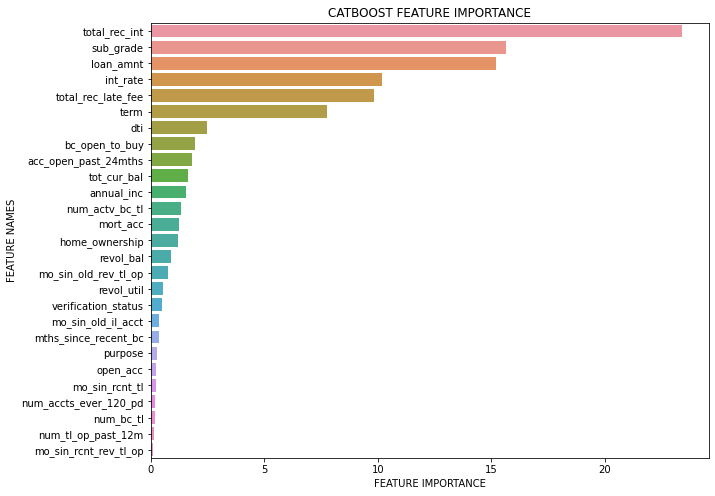

In [ ]:
#Reference :- https://www.analyseup.com/python-machine-learning/catboost-python-tutorial.html
import numpy as np
def plot_feature_importance(importance,names,model_type):
  #Create arrays from feature importance and feature names
  feature_importance = np.array(importance)
  feature_names = np.array(names)

  #Create a DataFrame using a Dictionary
  data={'feature_names':feature_names,'feature_importance':feature_importance}
  fi_df = pd.DataFrame(data)

  #Sort the DataFrame in order decreasing feature importance
  fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

  #Define size of bar plot
  plt.figure(figsize=(10,8))
  #Plot Searborn bar chart
  sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
  #Add chart labels
  plt.title(model_type + ' FEATURE IMPORTANCE')
  plt.xlabel('FEATURE IMPORTANCE')
  plt.ylabel('FEATURE NAMES')
plot_feature_importance(modelTest.get_feature_importance(),train_cbe.columns,'CATBOOST')